# Bienvenue dans ce nouveau notebook ! 

Nous sommes sur le point d'explorer des techniques de pointe en matière d'apprentissage automatique appliqué au trading algorithmique sur le marché des changes, ou Forex.

Dans ce projet, nous allons déployer un modèle de réseau de neurones LSTM (Long Short-Term Memory) multivarié pour prédire les rendements futurs d'un ensemble de paires de devises. Les LSTM sont particulièrement adaptés à la modélisation de séries temporelles comme les cours des devises, car ils sont capables de mémoriser les informations à long terme et d'apprendre de séquences de données temporelles, ce qui est idéal pour notre scénario.

L'approche multivariée signifie que nous allons inclure plusieurs séries de prix de devises comme entrées pour notre modèle. Cela nous permet de tirer parti des interactions et des dépendances entre différentes paires de devises. Le Forex étant un marché interconnecté, l'information contenue dans le mouvement de plusieurs paires de devises peut améliorer la performance de notre modèle de prédiction.

Ces prédictions seront la base de notre stratégie de trading. Si nos études montrent des résultats positifs, nous envisagerons d'implémenter cette approche dans un algorithme de trading en temps réel. En fin de compte, nous cherchons à développer une stratégie solide qui puisse naviguer avec succès dans le marché dynamique et souvent imprévisible du Forex.

Soyez prêt pour une exploration passionnante des possibilités offertes par l'apprentissage profond dans le domaine du trading algorithmique !

In [ ]:
import pandas as pd
import MetaTrader5 as mt5
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adamax, Adam
import sys
import matplotlib.pyplot as plt
sys.path.append(r'C:\Users\ftiag\Desktop\Business, trading et investissement\Business\modules')
from research_tools import get_clean_mt5_data
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr, pearsonr

mt5.initialize()

login_mt5 = 1051534030
mdp_mt5 = 'FG2SF2M74R'
server = 'FTMO-Demo'

mt5.login(login_mt5, mdp_mt5, server)

# Préparation des données pour le réseau de neurones LSTM

La préparation des données pour le modèle LSTM nécessite une structuration particulière, puisque les LSTM nécessitent des données d'entrée sous la forme d'un tenseur 3D. Cette forme de données est nécessaire pour exprimer les informations temporelles dans nos données, ainsi que pour gérer plusieurs séries d'entrées dans le cas d'un modèle multivarié.

La classe `RNNDatas` ci-dessus effectue précisément cette tâche. Elle commence par calculer les rendements logarithmiques de nos données sur le marché des changes. Ces rendements sont ensuite décalés pour créer un ensemble de données de séries temporelles décalées, ou lagged, qui serviront d'entrées à notre modèle LSTM. 

Les méthodes `get_returns` et `create_multivariate_rnn_data` s'occupent de ces étapes, respectivement. La méthode `create_multivariate_rnn_data` regroupe ensuite ces séries de rendements décalés en un seul tenseur 3D, prêt à être utilisé par notre modèle LSTM.

Ce tenseur 3D a une structure spécifique : il contient des informations sur le rendement de chaque devise à différents moments (dimension des "échantillons"), pour chaque devise (dimension des "caractéristiques") et pour chaque décalage temporel (dimension "temporelle"). 

Cette structuration de données permet à notre modèle LSTM d'apprendre à la fois des tendances temporelles au sein de chaque série de devises, mais aussi des interactions entre différentes paires de devises. 

En outre, cette classe fournit également des méthodes pour récupérer les informations sur les indices des devises (`get_index_to_ticker`) et les dates (`get_index_date`), ce qui sera utile pour l'interprétation de nos prédictions ultérieures.

In [12]:
class RNNDatas:
    
    def __init__(self, data, rnn_lag):
        
        self.data = data
        self.rnn_lag = rnn_lag
    
    def get_returns(self):
        
        returns = (self
                   .data
                   .groupby(level=0, group_keys=False)
                   .apply(lambda x: np.log(x.close/x.close.shift(1)))
                   .to_frame()
                   .rename(columns={'close' : 'returns'}))
        
        df_list = [returns]
        
        for lag in range(1, self.rnn_lag + 1):
            
            df_list.append(returns
                           .groupby(level=0, group_keys=False)
                           .apply(lambda x: x.returns.shift(lag))
                           .rename(f'returns_lag{lag}'))
            
        returns = pd.concat(df_list, axis=1)
            
        returns.dropna(how='any', inplace=True)
        
        return returns
    
    
    def create_multivariate_rnn_data(self):
        
        returns = self.get_returns()
        returns = returns.unstack(0).fillna(method='ffill').dropna().stack(level=1).swaplevel(0).sort_index()
        self.index_date = returns.index.get_level_values(1).unique()
        y = []
        X = []
        index_converter = {}
        for index, tick in enumerate(returns.index.levels[0]):
            
            index_converter[index] = tick
            y.append(np.array(returns.loc[tick].returns))
            X.append(np.array(returns.loc[tick].drop(['returns'], axis=1)))
        
        X = np.swapaxes(np.array(X).T, 0, 1)
        y = np.array(y).T
        self.index_converter = index_converter
        return X, y
    
    @property
    def get_index_to_ticker(self):
        return self.index_converter
    @property
    def get_index_date(self):
        return self.index_date
        

# Création du tenseur 3D pour notre modèle LSTM

La taille du tenseur créé pour notre modèle LSTM est de (6456, 300, 28). Cette taille correspond à la structure que nous avons décrite précédemment : 

- Nous avons 6456 échantillons temporels pour chacune de nos séries de devises. Chaque échantillon correspond à une observation de rendement à un moment donné.
- Pour chaque échantillon, nous avons 300 points de données temporels décalés, ou lagged. Ces points de données représentent l'historique des rendements pour la période de temps que nous avons choisie pour entrainer notre modèle LSTM. C'est ce que nous avons spécifié avec le paramètre `300` lors de la création de l'instance `RNNDatas`.
- Enfin, nous avons 28 séries différentes, correspondant à chacune de nos paires de devises. C'est ce que notre modèle LSTM utilisera pour apprendre les interactions entre différentes paires de devises.

Cette structure de données est donc prête à être utilisée pour entrainer notre modèle LSTM. Dans le prochain code, nous construirons et entrainerons ce modèle pour prédire les rendements futurs sur le marché des changes. Si nos tests et nos évaluations montrent que ce modèle donne des résultats précis et fiables, nous pourrons alors l'intégrer dans une stratégie de trading en temps réel pour notre portefeuille de devises.

In [13]:
tickers = ['AUDCAD', 'AUDJPY', 'AUDNZD', 'AUDCHF', 'AUDUSD', 'GBPAUD', 
           'GBPCAD', 'GBPJPY', 'GBPNZD', 'GBPCHF', 'GBPUSD', 'CADJPY',
           'CADCHF', 'EURAUD', 'EURGBP', 'EURCAD', 'EURJPY', 'EURCHF', 
           'EURUSD', 'EURNZD', 'NZDCAD', 'NZDCHF', 'NZDUSD', 'NZDJPY',
           'CHFJPY', 'USDCAD', 'USDCHF', 'USDJPY']

In [14]:
data = get_clean_mt5_data(tickers, interval=mt5.TIMEFRAME_H4, n_bars=6700)

In [16]:
clean_data = RNNDatas(data, 300)
X, y = clean_data.create_multivariate_rnn_data()

In [342]:
X.shape

(6456, 300, 28)

# Initialisation et entrainement du modèle LSTM

Nous avons maintenant nos données de marché préparées et nous sommes prêts à initialiser et entraîner notre modèle LSTM. 

Nous utilisons une architecture simple pour notre modèle, qui comprend une couche LSTM et une couche de sortie Dense. La couche LSTM a 128 unités, et l'input_shape est défini par la taille de notre fenêtre (300 points de données temporels) et le nombre de caractéristiques (28, correspondant à nos 28 paires de devises).

Notre couche de sortie Dense a le même nombre d'unités que le nombre de paires de devises, car nous prévoyons un rendement pour chaque paire de devises.

Il est à noter que, bien que la normalisation des données soit souvent une bonne pratique lors de l'entrainement des modèles de deep learning, nous avons trouvé que la multiplication de nos données par un facteur de 1000 donnait de meilleurs résultats dans ce cas. Cela aide à faciliter la convergence de l'algorithme de descente de gradient. Comme nos données de rendement sont toutes du même ordre de grandeur, l'utilisation d'un StandardScaler a peu d'effet.

Nous sommes maintenant prêts à entraîner notre modèle sur nos données d'entrainement, et ensuite à l'évaluer sur nos données de test. 

In [345]:
X *= 1000
y *= 1000
X_train, y_train = X[:-500], y[:-500]

X_test, y_test = X[-500:], y[-500:]

In [346]:
#scaler = StandardScaler()
#for i in range(X.shape[2]):
    #X[:, :, i] = scaler.fit_transform(X[:, :, i])

In [420]:
window_size = X.shape[1]
n_features = output_size = len(tickers)
lstm_units = 128
dense_units= 24

In [404]:
lstm_model = Sequential([
    LSTM(units=lstm_units,
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(output_size, name='Output')
])

In [405]:
lstm_model.summary()

Model: "sequential_394"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 256)               291840    
_________________________________________________________________
Output (Dense)               (None, 28)                7196      
Total params: 299,036
Trainable params: 299,036
Non-trainable params: 0
_________________________________________________________________


Après avoir défini notre modèle, nous avons procédé à la phase d'apprentissage. Pour cela, nous avons utilisé la fonction de perte "MeanAbsoluteError" et l'optimiseur "Adamax" avec un taux d'apprentissage de 0.3. De plus, nous avons mis en place une règle d'arrêt précoce (EarlyStopping) qui interrompt l'apprentissage si la perte sur le jeu de validation ne diminue pas pendant 3 époques consécutives.

Nous avons formé le modèle sur 10 époques, avec une taille de lot de 256, sans mélanger les données pour maintenir la dépendance temporelle entre nos observations. Nous avons également fourni nos données de test pour la validation durant l'apprentissage.

Une fois l'apprentissage terminé, nous avons utilisé notre modèle pour faire des prédictions sur l'ensemble de test. Nous avons tracé les rendements réels et les rendements prédits pour l'une des paires de devises.

Pour évaluer la performance de notre modèle, nous avons calculé le coefficient de corrélation de Spearman pour chaque paire de devises, puis nous avons calculé la moyenne de ces coefficients. Le coefficient de Spearman est une mesure de la corrélation non linéaire et monotonique entre les valeurs réelles et les prédictions.

Le score moyen que nous avons obtenu est de 0.0292, indiquant une corrélation assez faible entre les valeurs prédites et réelles. Dans le domaine de la finance, il est souvent difficile d'obtenir des scores élevés, c'est pourquoi nous utilisons un coefficient de corrélation. Un résultat de 3% peut être considéré comme correct, cependant il nécessite une analyse plus approfondie, comme une validation croisée, pour évaluer de manière plus précise la pertinence de notre modèle pour une utilisation dans une stratégie de trading en temps réel.

In [279]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [280]:
lstm_model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adamax(learning_rate=0.3))

In [ ]:
res = lstm_model.fit(X_train, 
                     y_train, 
                     epochs=10, 
                     batch_size=256, 
                     shuffle=False, 
                     validation_data=(X_test, y_test),
                     callbacks=[early_stop])

In [ ]:
preds = lstm_model.predict(X_test)

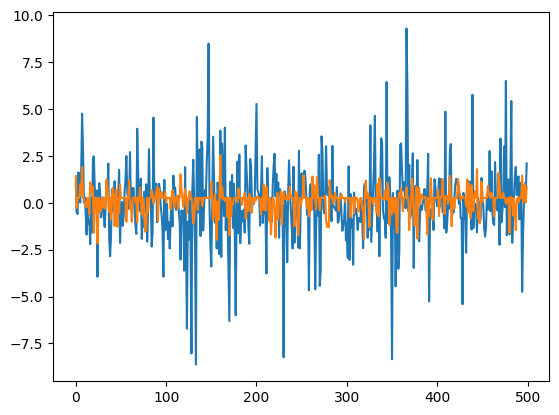

In [381]:
plt.plot(y_test[:500, 5])
plt.plot(preds[:500, 5])

In [383]:
score = []
for i in range(28):
    score.append(spearmanr(y_test[:100, i], preds[:100, i]).statistic)
    
np.mean(score)

0.029201957324833827

In [350]:
test_window = 500
train_window = 2000
n_splits = int(X.shape[0]/test_window-train_window/test_window-1)
val_window = 0
val_end = True
index_to_ticker = clean_data.get_index_to_ticker()
date_index = clean_data.get_index_date()

In [351]:
n_splits

7

Après avoir initialisé notre modèle RNN, nous avons effectué une validation croisée pour l'ajuster. Le découpage des données en sous-ensembles d'entraînement, de validation et de test se fait de manière séquentielle pour respecter l'ordre chronologique des données, un aspect essentiel lorsqu'on travaille avec des séries temporelles.

La boucle d'entraînement du modèle tourne sur chaque époque, entraînant le modèle sur l'ensemble d'entraînement et prédisant les rendements sur l'ensemble de test. Les prédictions sont stockées dans une liste pour une évaluation ultérieure.

Il est important de noter que j'ai testé différentes combinaisons de paramètres pour le modèle LSTM. Cependant, j'ai constaté qu'une petite quantité d'époques tend à produire de meilleurs résultats, ce qui suggère que le modèle peut avoir tendance à surajuster les données lorsqu'il est entraîné pendant trop longtemps. Cette observation n'est pas rare dans le domaine de la finance où les réseaux de neurones tendent à offrir des performances optimales avec un nombre réduit d'époques. 

La complexité et la volatilité des données financières peuvent rendre difficile l'obtention d'un modèle stable et performant. Les caractéristiques dynamiques et évolutives des marchés financiers imposent un défi supplémentaire qui doit être soigneusement pris en compte lors de la conception et de l'entraînement de modèles de machine learning dans ce domaine.

In [352]:
class MultivariateRNNCrossVal:
    
    def __init__(self, test_window, train_window, val_window, n_splits, val_end=False):
        
        self.test_window = test_window
        self.train_window = train_window
        self.n_splits = n_splits
        self.val_end = val_end
        self.val_window = val_window
        
    def split(self, X):
        
        add_window = 0
        for index in range(self.n_splits):
            
            
            if not self.val_end:
                train_idx = np.arange(add_window + val_window, self.train_window + add_window)
                val_idx = np.arange(add_window, val_window + add_window)
            else:
                train_idx = np.arange(add_window, self.train_window + add_window - val_window)
                val_idx = np.arange(self.train_window + add_window - val_window, self.train_window + add_window)
                
            test_idx = np.arange(self.train_window + add_window, self.test_window + self.train_window + add_window)
            add_window += self.test_window
            yield train_idx, val_idx, test_idx
            
    def get_n_splits(self):
        return self.n_splits
        

In [353]:
pd.DataFrame(date_index).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    6456 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 50.6 KB


In [449]:
cv = MultivariateRNNCrossVal(test_window=test_window,
                             train_window=train_window,
                             n_splits=n_splits,
                             val_window=val_window,
                             val_end=val_end)

lstm_model = Sequential([
                        LSTM(units=lstm_units,
                             input_shape=(window_size, n_features), name='LSTM'),
                        Dense(output_size, name='Output')
                        ])
lstm_model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adamax(learning_rate=0.1))

predictions = []
for i, (train_idx, val_idx, test_idx) in enumerate(cv.split(X)):
    if i%5 == 0:
        print(i)
    X_train, y_train = X[train_idx], y[train_idx]
    #X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    lstm_model.fit(X_train, 
                   y_train, 
                   epochs=1, 
                   batch_size=64, 
                   shuffle=False, 
                   #validation_data=(X_val, y_val),
                   verbose=1)
    preds = lstm_model.predict(X_test)
    df_preds = []
    for i in range(y_test.shape[1]):
        pred = preds[:, i]
        ticker = np.full(shape=pred.shape[0], fill_value=index_to_ticker[i])
        df_pred = pd.DataFrame({'ticker': ticker, 
                                'date': date_index[test_idx], 
                                'prediction': pred, 
                                'actual': y_test[:, i]})

        df_preds.append(df_pred)

    df_preds = pd.concat(df_preds, axis=0)
    df_preds = df_preds.set_index(['ticker', 'date'])
    predictions.append(df_preds)

0
32/32 [==============================] - 1s 18ms/step - loss: 1283.0247
5
32/32 [==============================] - 1s 18ms/step - loss: 1426.3845


Après avoir combiné toutes les prédictions en un seul dataframe, nous calculons le coefficient de corrélation de Spearman pour chaque paire de devises. Pour rappel, ce coefficient est une mesure de la corrélation non linéaire entre les valeurs réelles et les prédictions. Le tableau suivant montre les résultats obtenus :

|   Devise   | Coefficient de Spearman |
|:----------:|:----------------------:|
|   GBPJPY   |       0.0017           |
|   GBPUSD   |       0.0089           |
|   EURGBP   |       0.0321           |
|   EURUSD   |       0.0136           |
|   USDCAD   |       0.0170           |
|   USDJPY   |       0.0258           |

De plus, nous avons calculé le coefficient de corrélation de Spearman global qui est de 0.0194. Ces résultats confirment que le modèle a une faible corrélation avec les vrais rendements.

Il est important de noter que dans le domaine de la finance, il est souvent difficile d'obtenir des corrélations élevées entre les prédictions et les valeurs réelles. Les marchés financiers sont complexes, dynamiques et influencés par de nombreux facteurs, ce qui rend les prédictions précises extrêmement difficiles. Ainsi, obtenir des coefficients de corrélation faibles est une caractéristique courante dans le domaine de la finance.

Néanmoins, ces résultats fournissent une première indication de la performance du modèle et soulignent la nécessité d'une analyse plus approfondie et d'autres améliorations avant de pouvoir l'utiliser dans un contexte de trading en temps réel.

Finalement, nous avons enregistré les prédictions dans une base de données SQLite pour une utilisation future. Cela nous permettra de revenir à ces prédictions à tout moment sans avoir à re-exécuter l'ensemble du processus.

Maintenant, un petit coup d'oeil sur le contenu de notre base de données avec la requête SQL `SELECT * FROM first_lstm_predictions` confirme que les données ont été correctement sauvegardées.

Bien que ces résultats soient assez modestes, ils peuvent être considérés comme une première étape dans la création d'un système de prédiction pour le trading forex. Des améliorations pourraient être apportées en affinant les hyperparamètres du modèle, en incorporant d'autres caractéristiques, ou en utilisant des architectures de réseaux de neurones plus avancées.

In [450]:
epochs_dict

{1: SignificanceResult(statistic=0.021362710078344796, pvalue=0.0005180196835342677),
 2: SignificanceResult(statistic=0.011829235379600315, pvalue=0.054605822774210375),
 3: SignificanceResult(statistic=0.012623195543436631, pvalue=0.04026586567240341),
 5: SignificanceResult(statistic=0.016691361677129406, pvalue=0.0066861290620002295),
 6: SignificanceResult(statistic=0.025977653306625586, pvalue=2.428095515835097e-05),
 9: SignificanceResult(statistic=-0.0033378515740048117, pvalue=0.5876032330679882),
 12: SignificanceResult(statistic=0.005621093669980345, pvalue=0.3610934127508002),
 17: SignificanceResult(statistic=-0.002875271557982914, pvalue=0.640388860452715),
 25: SignificanceResult(statistic=0.01340012236487243, pvalue=0.029461410506384508)}

In [451]:
predictions = pd.concat(predictions, axis=0).loc[['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']]

In [452]:
for i in ['GBPJPY', 'GBPUSD', 'EURGBP', 'EURUSD', 'USDCAD', 'USDJPY']:
    
    print(spearmanr(predictions.loc[i]['prediction'], 
              predictions.loc[i]['actual']))

SignificanceResult(statistic=0.0016998228834486648, pvalue=0.9199259251983831)
SignificanceResult(statistic=0.008914205558173526, pvalue=0.5980591466822069)
SignificanceResult(statistic=0.03206046236509638, pvalue=0.057889663140344876)
SignificanceResult(statistic=0.013615487363781235, pvalue=0.4206738760000759)
SignificanceResult(statistic=0.017012022548419596, pvalue=0.3143395102271204)
SignificanceResult(statistic=0.025766638286934186, pvalue=0.1274878809569319)


In [453]:
spearmanr(predictions.prediction, predictions.actual)

SignificanceResult(statistic=0.019396746718553758, pvalue=0.004939503917788524)

In [454]:
predictions 

prediction       actual
ticker date                                        
GBPJPY 2020-07-31 20:00:00    0.301269  -382.355386
       2020-08-03 00:00:00    0.173575  1514.135826
       2020-08-03 04:00:00   -3.149590 -1903.855882
       2020-08-03 08:00:00    0.046480 -1365.217509
       2020-08-03 12:00:00    1.848788   397.477828
...                                ...          ...
USDJPY 2022-10-27 20:00:00   -1.671610   916.621698
       2022-10-28 00:00:00   15.502283  2376.563298
       2022-10-28 04:00:00   -5.416951 -2253.498997
       2022-10-28 08:00:00    2.789429  7912.608101
       2022-10-28 12:00:00    8.158754  1890.558278

[21000 rows x 2 columns]

In [455]:
import sqlite3

In [456]:
conn = sqlite3.connect('datas.db')
predictions.to_sql('first_lstm_predictions_300lag', conn, if_exists='replace', index=True)

21000

In [457]:
test = pd.read_sql_query("SELECT * FROM first_lstm_predictions", conn)
test.head()

,ticker,date,prediction,actual
0,GBPJPY,2020-05-20 12:00:00,-0.158069,0.849392
1,GBPJPY,2020-05-20 16:00:00,-0.158069,-3.143320
2,GBPJPY,2020-05-20 20:00:00,-0.158069,0.737365
3,GBPJPY,2020-05-21 00:00:00,-0.158069,-0.456038
4,GBPJPY,2020-05-21 04:00:00,-0.158069,-1.544472


In [458]:
conn.close()